In [1]:
# you need to create a .env file and put there your Hugging Face Token
# To create an Huggingface API Token you need to go here (https://huggingface.co/), 
# create an account and then create a token with WRITE permission

In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
from dotenv import load_dotenv

load_dotenv()
HF_API_TOKEN = os.getenv('HF_API_TOKEN')


## Haystack Framework to Build Your Own Rag System

To create our RAG System, we will use the open-source framework Haystack (https://haystack.deepset.ai/).\
Install Haystack via pip

```python
pip install haystack-ai

Haystack is based on 2 main concepts:

- **COMPONENTS**: Components are the building blocks of a pipeline. They perform tasks such as preprocessing, retrieving, or summarizing text while routing queries through different branches of a pipeline (https://docs.haystack.deepset.ai/docs/components).

- **PIPELINES**: Pipelines orchestrates the flow of data and operations. A pipeline in Haystack consists of different components, such as retrievers, readers, generators, and other modules, that work together to process queries and provide accurate, meaningful results (https://docs.haystack.deepset.ai/docs/pipelines).

### Let's create your first search pipeline!

First, we need to have some documents and store them in a document store. Then, we create a search pipeline to retrieve the documents from the store and provide them as results of the pipeline. \
(Note that here we aren't using any generators to provide a response)

#### Create a indexing pipeline

In [17]:
# Creating the document store. Here we use the InMemoryDocumentStore, that stores data in-memory. 
# It's ephemeral and cannot be saved to disk.

from haystack.document_stores.in_memory import InMemoryDocumentStore

document_store = InMemoryDocumentStore()

To store some documents into the document store we need 4 components:
- **Converter**: Use various Converters to extract data from files in different formats and cast it into the unified document format.
- **Splitter**: It divides a list of text documents into a list of shorter text documents. This is useful for long texts that otherwise wouldn't fit into the maximum text length of language models and can also speed up question answering.
- **Embedder**: Embedders in Haystack transform texts or Documents into vector representations using pre-trained models. 
- **Writer**: Use this component to write documents into a Document Store.

In [18]:
from haystack import Pipeline

In [19]:
from haystack.components.converters.txt import TextFileToDocument
from haystack.components.preprocessors.document_splitter import DocumentSplitter
from haystack.components.embedders import SentenceTransformersDocumentEmbedder 
from haystack.components.writers import DocumentWriter

In [20]:
converter = TextFileToDocument()
splitter = DocumentSplitter(split_by='sentence', split_length=1)
embedder = SentenceTransformersDocumentEmbedder("sentence-transformers/all-MiniLM-L6-v2")
writer = DocumentWriter(document_store=document_store)

indexing_pipeline = Pipeline()

indexing_pipeline.add_component("converter", converter)
indexing_pipeline.add_component("splitter", splitter)
indexing_pipeline.add_component("embedder", embedder)
indexing_pipeline.add_component("writer", writer)

In [21]:
indexing_pipeline.connect("converter.documents", "splitter.documents")
indexing_pipeline.connect("splitter.documents", "embedder.documents")
indexing_pipeline.connect("embedder.documents", "writer.documents")

🚅 Components
  - converter: TextFileToDocument
  - splitter: DocumentSplitter
  - embedder: SentenceTransformersDocumentEmbedder
  - writer: DocumentWriter
🛤️ Connections
  - converter.documents -> splitter.documents (List[Document])
  - splitter.documents -> embedder.documents (List[Document])
  - embedder.documents -> writer.documents (List[Document])

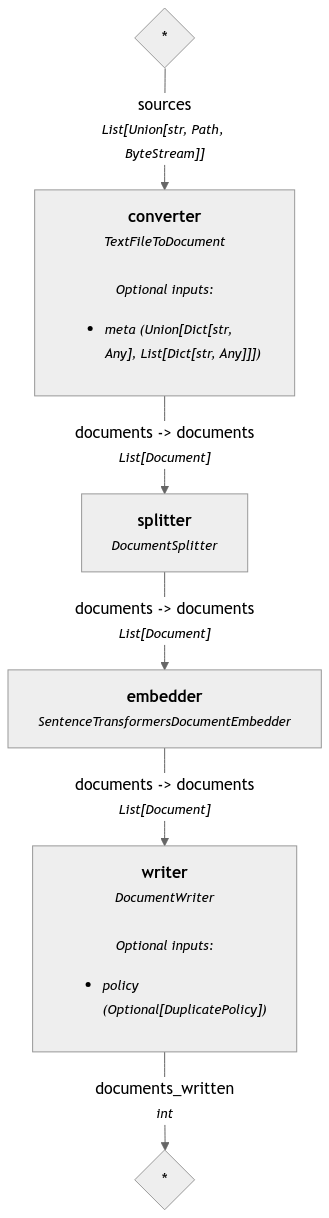

In [22]:
indexing_pipeline.show()

In [23]:
indexing_pipeline.run({"converter": {"sources": ["/Users/simonamazzarino/Documents/Clearbox-repo/clearbox-ai-academy/RAG_Course/data/tolkien.txt"]}})

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

{'writer': {'documents_written': 55}}

In [24]:
document_store.filter_documents()[0], document_store.filter_documents()[1]

(Document(id=4db796e36bf997d5b6962fb24e58b14064b0d001778edfe8caf9f8db3fdd041b, content: 'John Ronald Reuel Tolkien, born on January 3, 1892, in Bloemfontein, South Africa, is widely regarde...', meta: {'file_path': '/Users/simonamazzarino/Documents/Clearbox-repo/clearbox-ai-academy/RAG_Course/data/tolkien.txt', 'source_id': '95729082efb874f6adbd167b40d517e72164716f13b409e93ef114cbc81fcb5d', 'page_number': 1, 'split_id': 0, 'split_idx_start': 0}, embedding: vector of size 384),
 Document(id=ca30af9db39112b8b30b423b5eecde1179eaa937cf246b3a2dc3370d613defc5, content: ' His works have left an indelible mark on literature, shaping and defining the modern fantasy genre....', meta: {'file_path': '/Users/simonamazzarino/Documents/Clearbox-repo/clearbox-ai-academy/RAG_Course/data/tolkien.txt', 'source_id': '95729082efb874f6adbd167b40d517e72164716f13b409e93ef114cbc81fcb5d', 'page_number': 1, 'split_id': 1, 'split_idx_start': 223}, embedding: vector of size 384))

#### Create a document search pipeline

In [25]:
from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever

query_embedder = SentenceTransformersTextEmbedder("sentence-transformers/all-MiniLM-L6-v2")
retriever = InMemoryEmbeddingRetriever(document_store=document_store)

document_search = Pipeline()

document_search.add_component("query_embedder", query_embedder)
document_search.add_component("retriever", retriever)

document_search.connect("query_embedder.embedding", "retriever.query_embedding")

🚅 Components
  - query_embedder: SentenceTransformersTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
🛤️ Connections
  - query_embedder.embedding -> retriever.query_embedding (List[float])

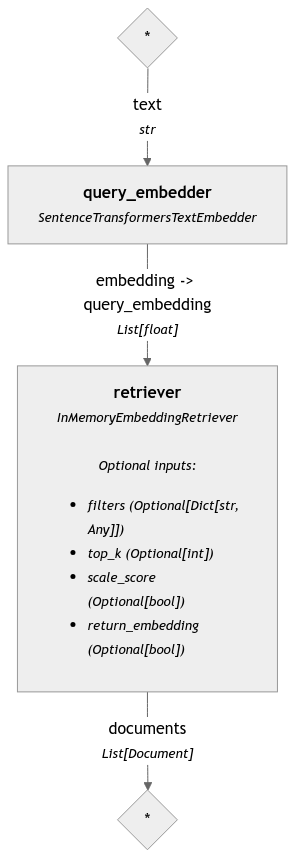

In [26]:
document_search.show()

In [27]:
question = "Where J.R.R. was born?"

results = document_search.run({"query_embedder": {"text": question},
                               "retriever": {"top_k": 3}}) #as default are 10

for i, document in enumerate(results["retriever"]["documents"]):
    print("\n--------------\n")
    print(f"DOCUMENT {i}")
    print(document.content)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


--------------

DOCUMENT 0
John Ronald Reuel Tolkien, born on January 3, 1892, in Bloemfontein, South Africa, is widely regarded as one of the most influential and celebrated figures in literary history, particularly within the realm of high fantasy.

--------------

DOCUMENT 1
 He graduated in 1915, but his scholarly ambitions were interrupted by the outbreak of World War I.

--------------

DOCUMENT 2
 His work as a philologist allowed him to delve into the history, structure, and evolution of language, further fueling his creative endeavors.


### Bonus
When you upload data to the document store, you always need to split your documents (unless you're working with very short documents). This step is part of the text pre-processing steps. However, in some cases, such as when working with texts downloaded from the web, it may be important to clean the texts.

Haystack provides the following component for text cleaning:

- **Document Cleaner**: It removes extra whitespaces, empty lines, specified substrings, regexes, page headers, and footers in this particular order. This is useful for preparing the documents for further processing by LLMs. This component is used in the pipeline after the converter and before the splitter



In [29]:
from haystack.components.preprocessors import DocumentCleaner

cleaner = DocumentCleaner(
  ascii_only=True,
	remove_empty_lines=True,
	remove_extra_whitespaces=True,
	remove_repeated_substrings=False)